In [2]:
import os
import pandas as pd
import keras
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imsave
import tensorflow as tf
import splitfolders

In [14]:
#Creamos los directorios de entrenamiento testeo y validación
classes=['french_bulldog','german_shepherd','golden_retriever','poodle']
dataset_dir='dogs'
#Se opta por dividir el dataset en 80% entrenamiento, 10% testeo y 10% validación
splitfolders.ratio(dataset_dir, output="output", seed=1337, ratio=(0.8, 0.1,0.1), group_prefix=None) # default values


Copying files: 80 files [00:00, 599.76 files/s]


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Preprocesamiento de las imagenes para obtener mas variabilidad de las pocas fotos que tenemos
train_data_gen = ImageDataGenerator(rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
valid_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
test_data_gen = ImageDataGenerator(
                                    rescale=1./255)


In [16]:
#Parametros del modelo con el que vamos a trabajar
Batch_size = 8
img_h = 256
img_w = 256

In [30]:
#Por temas de reproducibilidad se fija la semilla
SEED = 1234
tf.random.set_seed(SEED) 
#Se crean los directorios de entrenamitno, testeo y validación 
training_dir = os.path.join('output', 'train')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(256, 256),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  
# Validation
valid_dir = os.path.join('output', 'val')
valid_gen = valid_data_gen.flow_from_directory(valid_dir,
                                           target_size=(256, 256),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)
test_dir = os.path.join('output', 'test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                           target_size=(256, 256),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)


Found 64 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 8 images belonging to 4 classes.


In [45]:


#Importamos el  modelo ResNet152V2 y realizamos transfer training, a su vez agregamos capas densa par ala clasificación final y dropout para evitar overfitting
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
     

from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

#Se fijan los pesos de imagenet y se congelan las capas de la red a excepecion de las que agregamos nosotros para finetuneear el modelo
for layer in ResNet_model.layers[:-5]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=4, activation='softmax')(x)
model = Model(ResNet_model.input, output)

model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [46]:
#Definimos la función de perdida y el optimizador 
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'],run_eagerly=True)

In [47]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#Se reduce la tasa de aprendizaje si la accuracy no mejora en 3 epochs
lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.0001)


callbacks = [lrr]

In [48]:
#Definimos tamaño del step para el entrenamiento y validación
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size
#Entrenamos el modelo
transfer_learning_history = model.fit(train_gen,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=20,
                  callbacks=callbacks,verbose=1
                  
                    
)


Epoch 1/20
6/6 [==============================] - 69s 10s/step - loss: 1.8814 - accuracy: 0.2083 - val_loss: 1.9935 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 2/20
6/6 [==============================] - 67s 12s/step - loss: 0.7983 - accuracy: 0.6875 - val_loss: 1.1788 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/20
6/6 [==============================] - 70s 12s/step - loss: 0.5155 - accuracy: 0.8125 - val_loss: 0.4747 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 4/20
6/6 [==============================] - 70s 12s/step - loss: 0.3538 - accuracy: 0.8958 - val_loss: 2.9232 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 5/20
6/6 [==============================] - 62s 10s/step - loss: 0.3629 - accuracy: 0.8750 - val_loss: 3.1379 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 6/20
6/6 [==============================] - ETA: 0s - loss: 0.2939 - accuracy: 0.9167
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
6/6 [==============================] - 67s 11s/step - loss: 0.2939 - acc

In [9]:
#model.save('modelo0604.h5')
model=keras.models.load_model('modelo0604.h5')

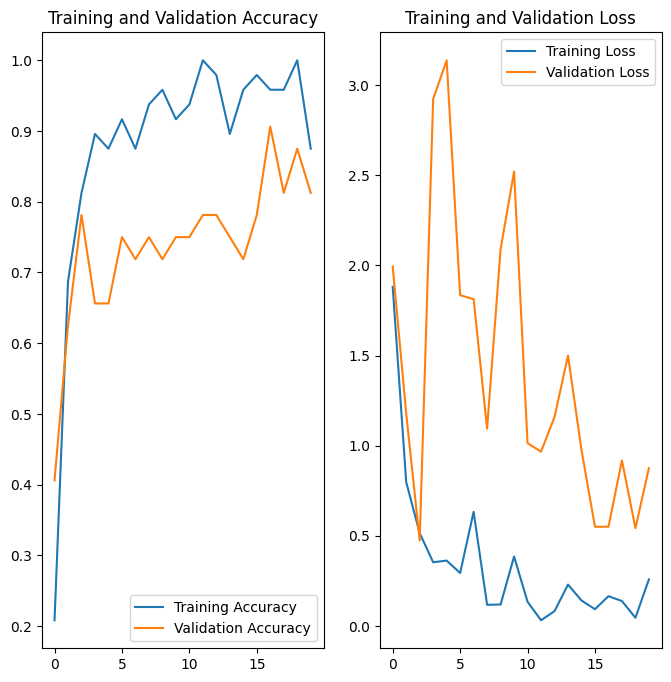

In [50]:
#Visualización de la accuracy y la loss a lo largo de los epochs
acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
valid_gen.reset()
model.evaluate(valid_gen, steps=STEP_SIZE_VALID,verbose=1)


4/4 [==============================] - 6s 2s/step - loss: 0.7576 - accuracy: 0.7812


[0.757612943649292, 0.78125]

1/1 [==============================] - 3s 3s/step
['french_bulldog', 'french_bulldog', 'german_shepherd', 'german_shepherd', 'golden_retriever', 'golden_retriever', 'poodle', 'poodle']


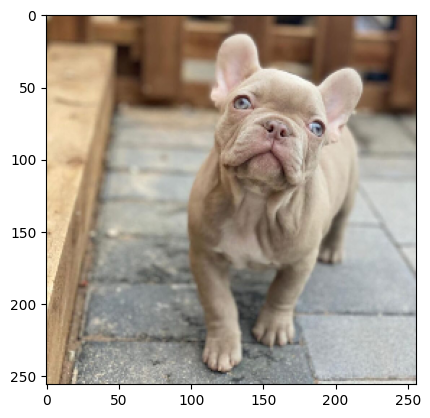

In [32]:
test_gen.reset()
labels = test_gen.class_indices
labels = dict((v,k) for k,v in labels.items())
pred=model.predict(test_gen,
steps=1,
verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
predictions = [labels[k] for k in predicted_class_indices]
print(predictions)
plt.imshow(test_gen[0][0][1])

In [13]:
from keras.applications.resnet import preprocess_input
x=keras.utils.load_img('output/train/golden_retriever/6acafd7e5aa78e12675647275ebec6b3.jpg', target_size=(256, 256))
x=keras.utils.img_to_array(x)
x=np.expand_dims(x, axis=0)
x=preprocess_input(x)
#plt.imshow(x)
pred = model.predict(x)
score= tf.nn.softmax(pred)
print(score)
     

1/1 [==============================] - 3s 3s/step
tf.Tensor([[0.17487772 0.47536692 0.17487772 0.17487772]], shape=(1, 4), dtype=float32)
